# Introduction

* The data used for this project is from https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv

* This page is part of an adjacent project that tackles the same dataset but instead with a Random Forest approach

As one of the most prevalent health issues facing many people today, Diabetes is a health condition that changes the way you gain energy from food. Generally speaking, a common cause of Diabetes, aside from genetics in some cases, is the excessive intake of sugary foods. However, there are other ways to determine the presence of Diabetes and even have early diagnoses of Pre-Diabetes. Today, I am looking to create an additional predictor by regressing a data model to predict if someone is at risk of getting Diabetes.
\
\
The data used in the project, after being pre-cleaned by a generous Kaggle user, was obtained from an annual CDC health-related telephone survey from 2015 in which the dataset contains about 250,000 instances of citizens reporting answers to 22 different categorical-based questions, all of which seemingly revolve around Diabetes. Here we will use logistic regression in R to see if we can create an accurate prediction model.
\
\
The questions in the data set that were asked include

* Diabetes_binary: 0 is no diabetes, 1 is prediabetic, and 2 is diabetic
* HighBP: 0 for no high blood pressure and 1 for high blood pressure
* HighCol: 0 for no high cholesterol and 1 for high cholesterol
* CholCheck: 0 for no cholesterol check in 5 years and 1 for a cholesterol check in 5 years
* BMI: The BMI of the subject
* Smoker: (0 == not smoked 100 cigarettes total)(1 == smoked at least 100 cigarettes)
* Stroke: (0 == not had a stroke)(1 == had a stroke)
* HeartDiseaseorAttack: (0 == not had heart disease/attack)(1 == had heart disease/attack)
* PhysActivity: (0 == not had physical activity in the past 30 days)(1 == had physical activity in the past 30 days)
* Fruits: (0 == not consumed at least 1 fruit a day)(1 == consumed at least 1 fruit a day)
* Veggies: (0 == not consumed at least 1 vegetable a day)(1 == consumed at least 1 vegetable a day)
* HvyAlcoholConsump: (0 == men<14 drinks per week, women<7 drinks per week)(1 == men>=14 drinks per week, women>=7 drinks per week)
* AnyHealthcare: (0 == no healthcare)(1 == healthcare)
* NoDocbcCost: (0 == did not go to doctor in the past year due to cost)(1 == did go to the doctor in the past year)
* GenHlth: Rate general health 1-5 (1 = excellent, 5 = poor)
* MentHlth: Days of poor mental health in the past 30 days (0-30)
* PhysHlth: Days of poor physical health in the past 30 days (0-30)
* DiffWalk: (0 == had no difficulty walking/climbing stairs)(1 == had difficulty walking/climbing stairs)
* Sex: (0 == female)(1 == male)
* Age: Age of subject
* Education: (1 == no school/only kindergarten, 2 == elementary, etc. 1-6)
* Income: (1 == less than $10,000, 8 == $75,000 or more, etc. 1-8)

In [1]:
library(digest)
library(stringr)
library(glmnet) #to do logistic regression with regularization
library(latex2exp) #used for including some latex in plots
library(pROC) #used for plotting ROC curve

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following object is masked from 'package:glmnet':

    auc

The following objects are masked from 'package:stats':

    cov, smooth, var



### Importing and cleaning the data
\
First we will go ahead and input the data and take a look at some metrics to determine if there is any additional cleaning that we need to perform.



In [2]:
data = read.csv("diabetes_binary_health_indicators_BRFSS2015.csv")
head(data)
dim(data)

Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
0,1,1,1,25,1,0,0,1,1,...,1,0,2,0,2,0,1,10,6,8


[1] 253680     22

In [3]:
sum(is.na(data))

[1] 0


While the user before us did a fantastic job at making each instance void of data holes, in order to keep to our categorical nature, we need to adjust the data types of most of the variables. The only ones we will leave as ints are the BMI and the Age.

In [4]:
data[,c('Diabetes_binary','HighBP','HighChol','CholCheck',
       'Smoker','Stroke','HeartDiseaseorAttack','PhysActivity',
       'Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare',
       'NoDocbcCost','GenHlth','MentHlth','PhysHlth','DiffWalk',
       'Sex','Education','Income')] = lapply(data[,c('Diabetes_binary','HighBP','HighChol','CholCheck',
       'Smoker','Stroke','HeartDiseaseorAttack','PhysActivity',
       'Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare',
       'NoDocbcCost','GenHlth','MentHlth','PhysHlth','DiffWalk',
       'Sex','Education','Income')], FUN=as.factor)

Perfect! And now that we have everything in order we will go ahead and begin our path to creating a model.

# Prepping Data for Model

\
After setting a seed to keep results reproducable, we will elect to use a standard 70-30 split on the train and test data.

In [5]:
set.seed(227)
trainidx = sample(1:nrow(data),size=0.7*nrow(data),replace=FALSE)


train = data[trainidx, ]
test = data[-trainidx, ]

dim(data)

#verify proportions
noquote(paste("proportion of train data:",nrow(train)/nrow(data)))
noquote(paste("proportion of test data:",nrow(test)/nrow(data)))

[1] 253680     22

[1] proportion of train data: 0.7

[1] proportion of test data: 0.3

In [6]:
#get response vector y and predictor matrix (in fact, data frame) X from diabetes data
y = train$Diabetes_binary
X = train[ ,!(names(train) %in% "Diabetes_binary")] #all but Diabetes_binary
dim(X)

[1] 177576     21

In [7]:
str(X)

'data.frame':	177576 obs. of  21 variables:
 $ HighBP              : Factor w/ 2 levels "0","1": 2 1 1 2 1 1 1 2 1 1 ...
 $ HighChol            : Factor w/ 2 levels "0","1": 2 1 2 1 2 1 1 2 1 1 ...
 $ CholCheck           : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 1 ...
 $ BMI                 : num  32 20 22 31 27 28 22 26 25 24 ...
 $ Smoker              : Factor w/ 2 levels "0","1": 1 1 1 2 2 1 1 2 1 2 ...
 $ Stroke              : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ HeartDiseaseorAttack: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ PhysActivity        : Factor w/ 2 levels "0","1": 2 1 1 2 2 2 2 1 2 2 ...
 $ Fruits              : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 1 2 2 1 ...
 $ Veggies             : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ HvyAlcoholConsump   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ AnyHealthcare       : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 2 2 2 ...
 $ NoDocbcCost         : Factor w/ 2 levels "

In [8]:
# make sure X does not contain response values
X = model.matrix( ~ . , data=X)[,-1]

dim(X)

X[1:5,]

[1] 177576     92

,HighBP1,HighChol1,CholCheck1,BMI,Smoker1,Stroke1,HeartDiseaseorAttack1,PhysActivity1,Fruits1,Veggies1,...,Education4,Education5,Education6,Income2,Income3,Income4,Income5,Income6,Income7,Income8
134529,1,1,1,32,0,0,0,1,1,1,...,1,0,0,0,0,0,0,0,1,0
155353,0,0,1,20,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,0
214608,0,1,1,22,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
82275,1,0,1,31,1,0,0,1,1,1,...,0,1,0,0,0,0,0,0,1,0
70691,0,1,1,27,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1


# Logistic Regression with Lasso Regulation

\
I chose to utilize Lasso Regulation as, unlike Ridge Regulation, it allows possible useless variables to have their biases reduced to zero if the model deems it fit. So we will go ahead and begin the process

In [9]:
mylambda=seq(0,2,by=0.005) 

cvfit = cv.glmnet(X,y,family = "binomial",lambda=mylambda,type.measure="deviance", nfolds = 10, alpha = 1) 

In [10]:
coef(cvfit)

93 x 1 sparse Matrix of class "dgCMatrix"
                                 1
(Intercept)           -7.685663426
HighBP1                0.735624172
HighChol1              0.590711167
CholCheck1             1.243553236
BMI                    0.059704766
Smoker1               -0.013467092
Stroke1                0.155033226
HeartDiseaseorAttack1  0.205638974
PhysActivity1         -0.050756261
Fruits1               -0.058693261
Veggies1              -0.023860199
HvyAlcoholConsump1    -0.719403949
AnyHealthcare1         0.098696778
NoDocbcCost1           0.029714451
GenHlth2               0.697502669
GenHlth3               1.402443808
GenHlth4               1.825803851
GenHlth5               2.000134425
MentHlth1             -0.186397775
MentHlth2             -0.123685092
MentHlth3             -0.142892373
MentHlth4             -0.080851855
MentHlth5             -0.153322363
MentHlth6              0.034281881
MentHlth7             -0.100292366
MentHlth8              0.166418029
MentHlth9    

Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"

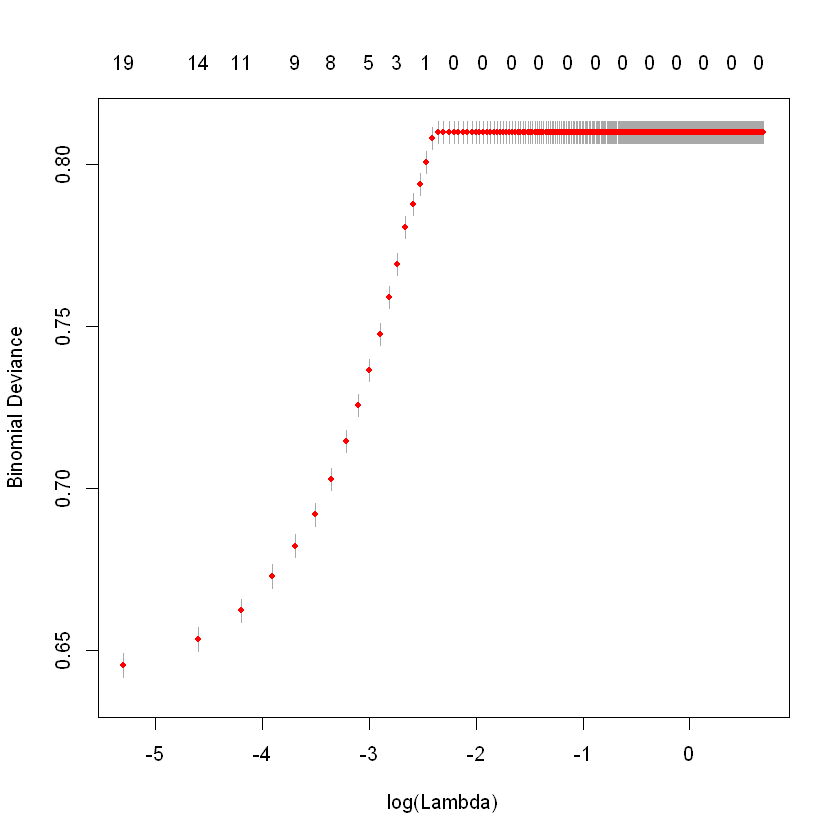

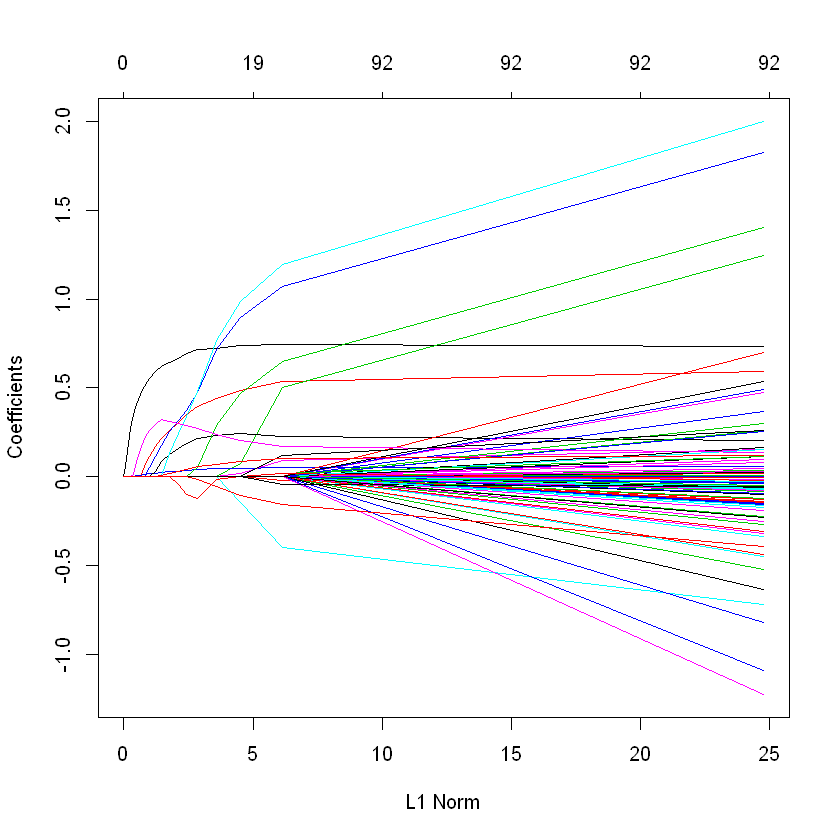

In [11]:
#plot Lasso based on deviance measure
plot(cvfit)  #note on x-axis in the plot is log(lambda), not log(1/lambda)

#plot coefficients for various models; ignore the warning message
plot(cvfit$glmnet.fit)

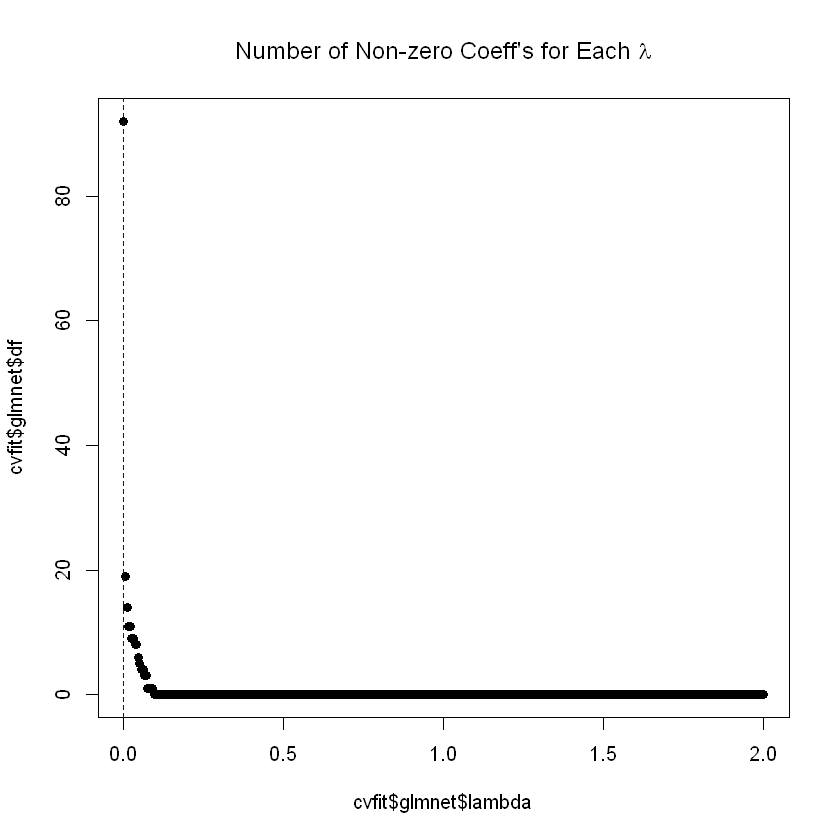

In [12]:
##Number of non-zero coefficients vs. $\lambda$

plot(cvfit$glmnet$lambda,cvfit$glmnet$df, 
     main=TeX("Number of Non-zero Coeff's for Each $\\lambda$"),pch=16)
abline(v=cvfit$lambda.min,col="red",lty="dashed")
abline(v=cvfit$lambda.1se,col="blue",lty="dashed")

### Interpretation

So as we can see from the graphs, the lasso regulation on the pure data set did reduce many of the coefficients to low values, but none quite yet to zero. Additionally there does seem to be a handful of variables that are more significant then the majority. But now we need to see how well it fares against the test data.

In [13]:
ytest = test$Diabetes_binary
Xtest = test[ ,!(names(test) %in% "Diabetes_binary")]

Xtest = model.matrix( ~ ., data=Xtest)[,-1]
pihat = predict(object=cvfit, newx = Xtest, type="response")

Setting levels: control = FALSE, case = TRUE
Warning message in roc.default(response = ylogical, predictor = pihat):
"Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector."Setting direction: controls < cases


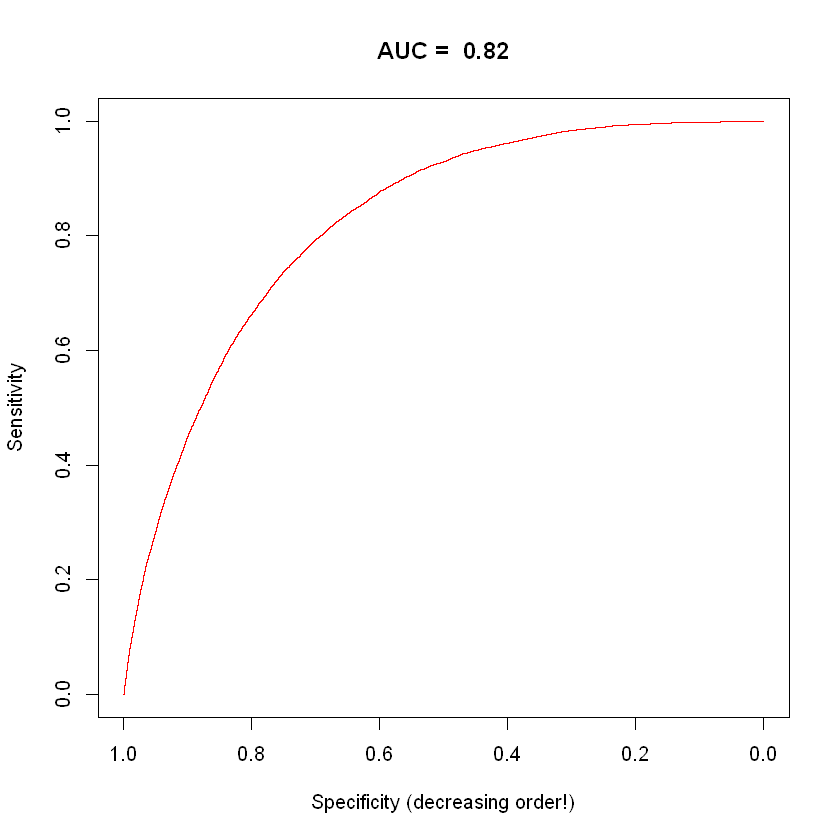

In [14]:
ylogical = (ytest == 1)
ROCcrv = roc(response=ylogical, predictor=pihat)
AUC = auc(ROCcrv)

plot(x=ROCcrv$specificities,y=ROCcrv$sensitivities, main=paste("AUC = ",round(AUC,2)), 
     xlab="Specificity (decreasing order!)", ylab="Sensitivity", xlim=c(1,0), type="l", col="red")

In [15]:
yhat = ifelse(pihat>0.5,"1","0")
tbl = table(yhat, ytest)

tbl

    ytest
yhat     0     1
   0 64224  8902
   1  1391  1587

In [16]:
acc = (tbl[1,1]+tbl[2,2])/sum(tbl)

FNR = tbl[1,2]/sum(tbl[,2])

In [17]:
acc

[1] 0.8647509

In [18]:
FNR

[1] 0.8486986

Yikes! High accuracy but also a high false negative rate. Especially since we are dealing with a serious illness, we need to think of something to reduce that rate. Let's take a look at the response variable composition and see if there's anything fishy.

In [49]:
table(data$Diabetes_binary)


     0      1 
218334  35346 

Well that would be a reason as to why the model is so off. Because the response variable is not balanced, this introduces a lot of bias to the machine, making it more likely to choose one side over the other off of pure population instead of other variables. To address this, we are going to have to try to balance the response variable.

# Data Balancing

\
There are different kinds of balancing that we can do and we are going to try two options: down-sampling and up-sampling.

* Down-sampling: Sampling the dataset to use all of the minority data values but only a sample of the majority values equal to the minority total
* Up-sampling: Sampling the dataset to use all of the majority data values and then sample of the minority values with replacement to equal to the majority total

\
Let's start with down-sampling

In [19]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [20]:
# Ensure the input data does not have response variable answers
down_data = downSample(data[,-1], data$Diabetes_binary, yname="Diabetes_binary")
str(down_data)

'data.frame':	70692 obs. of  22 variables:
 $ HighBP              : Factor w/ 2 levels "0","1": 1 1 2 1 2 1 2 2 2 1 ...
 $ HighChol            : Factor w/ 2 levels "0","1": 1 2 1 1 1 1 1 1 1 1 ...
 $ CholCheck           : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 1 ...
 $ BMI                 : num  33 40 28 27 48 23 24 42 30 20 ...
 $ Smoker              : Factor w/ 2 levels "0","1": 1 2 1 2 1 2 2 1 1 2 ...
 $ Stroke              : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 1 1 ...
 $ HeartDiseaseorAttack: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 1 1 ...
 $ PhysActivity        : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Fruits              : Factor w/ 2 levels "0","1": 2 1 1 1 1 2 1 1 1 2 ...
 $ Veggies             : Factor w/ 2 levels "0","1": 2 1 1 1 2 2 2 2 1 2 ...
 $ HvyAlcoholConsump   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 2 1 1 ...
 $ AnyHealthcare       : Factor w/ 2 levels "0","1": 2 2 2 1 2 2 2 2 2 2 ...
 $ NoDocbcCost         : Factor w/ 2 levels "0

Now that we've down-sampled, we just repeat the process as usual just with the down_data set instead.

In [21]:
set.seed(227)
trainidx = sample(1:nrow(down_data),size=0.7*nrow(down_data),replace=FALSE)


train = down_data[trainidx, ]
test = down_data[-trainidx, ]

dim(down_data)

#verify proportions
noquote(paste("proportion of train data:",nrow(train)/nrow(down_data)))
noquote(paste("proportion of test data:",nrow(test)/nrow(down_data)))

[1] 70692    22

[1] proportion of train data: 0.699994341651106

[1] proportion of test data: 0.300005658348894

In [22]:
# verify the input and output data stay separate
y = train$Diabetes_binary
X = train[ ,!(names(train) %in% "Diabetes_binary")] #all but Diabetes_binary
dim(X)

[1] 49484    21

In [23]:
X = model.matrix( ~ . , data=X)[,-1]

dim(X)

X[1:5,]

[1] 49484    92

,HighBP1,HighChol1,CholCheck1,BMI,Smoker1,Stroke1,HeartDiseaseorAttack1,PhysActivity1,Fruits1,Veggies1,...,Education4,Education5,Education6,Income2,Income3,Income4,Income5,Income6,Income7,Income8
3457,1,1,1,28,1,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
24281,0,0,1,27,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
33446,1,0,1,23,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
10778,0,0,1,22,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
11227,0,1,1,30,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0


In [24]:
cvfit = cv.glmnet(X,y,family = "binomial",lambda=mylambda,type.measure="deviance", nfolds = 10, alpha = 1) 

In [25]:
coef(cvfit)

93 x 1 sparse Matrix of class "dgCMatrix"
                                 1
(Intercept)           -6.630320262
HighBP1                0.724649391
HighChol1              0.608657332
CholCheck1             1.347591755
BMI                    0.072515737
Smoker1               -0.028138166
Stroke1                0.145160023
HeartDiseaseorAttack1  0.248651646
PhysActivity1         -0.081266475
Fruits1               -0.043757049
Veggies1              -0.013259499
HvyAlcoholConsump1    -0.775685902
AnyHealthcare1         0.094266968
NoDocbcCost1           0.003890817
GenHlth2               0.707541520
GenHlth3               1.390513927
GenHlth4               1.856990500
GenHlth5               1.947138081
MentHlth1             -0.263530342
MentHlth2             -0.090943494
MentHlth3             -0.228928791
MentHlth4             -0.147959318
MentHlth5             -0.190036437
MentHlth6             -0.100784032
MentHlth7             -0.117071438
MentHlth8             -0.328885862
MentHlth9    

Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"

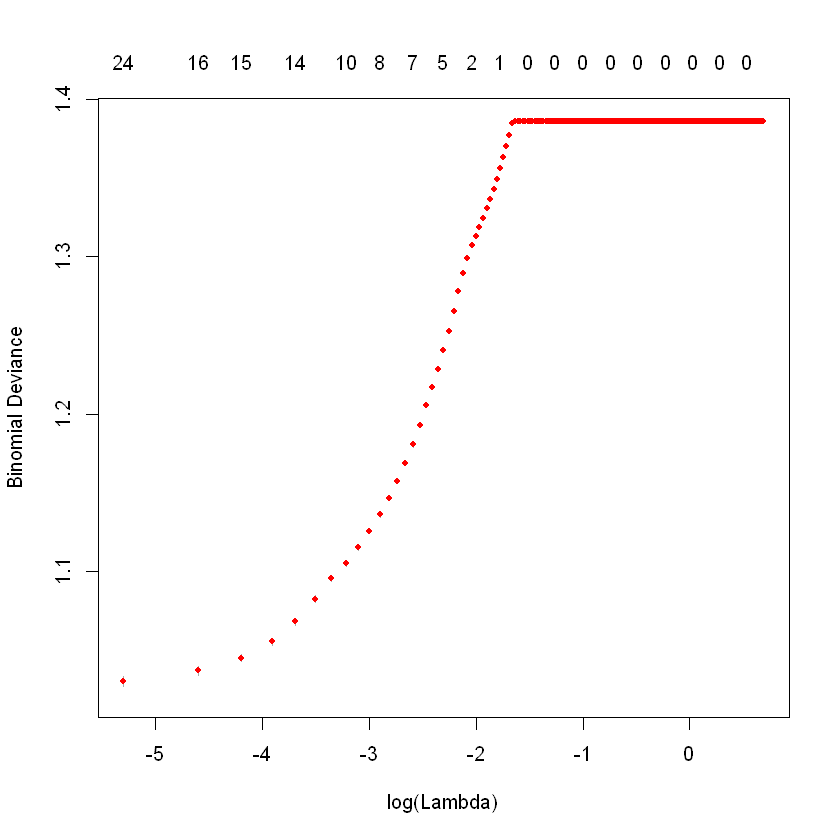

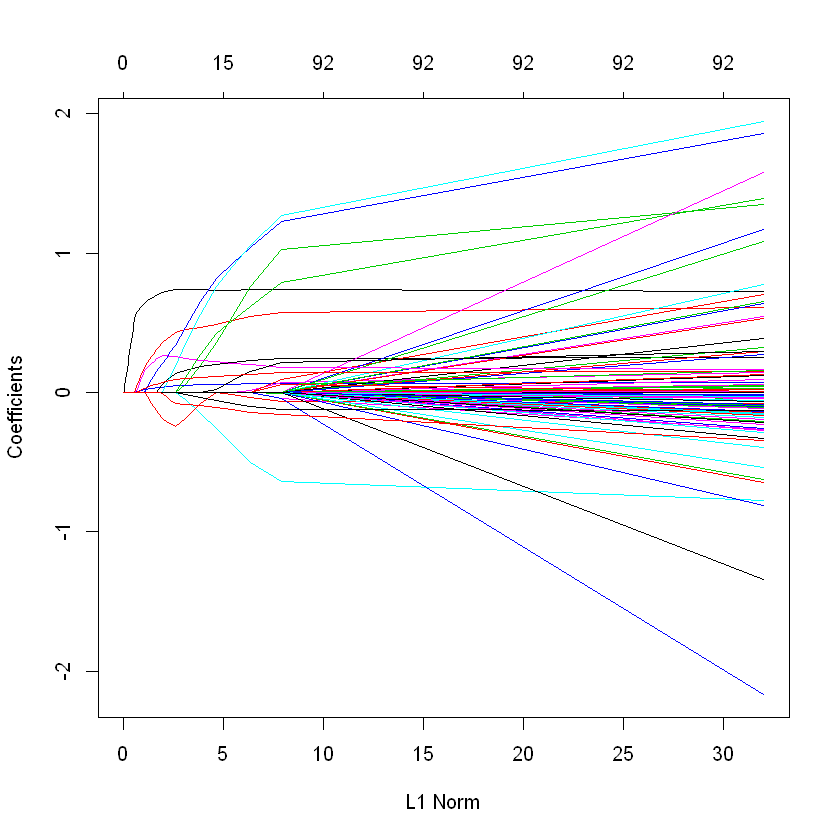

In [26]:
#plot Lasso based on deviance measure
plot(cvfit)  #note on x-axis in the plot is log(lambda), not log(1/lambda)

#plot coefficients for various models; ignore the warning message
plot(cvfit$glmnet.fit)

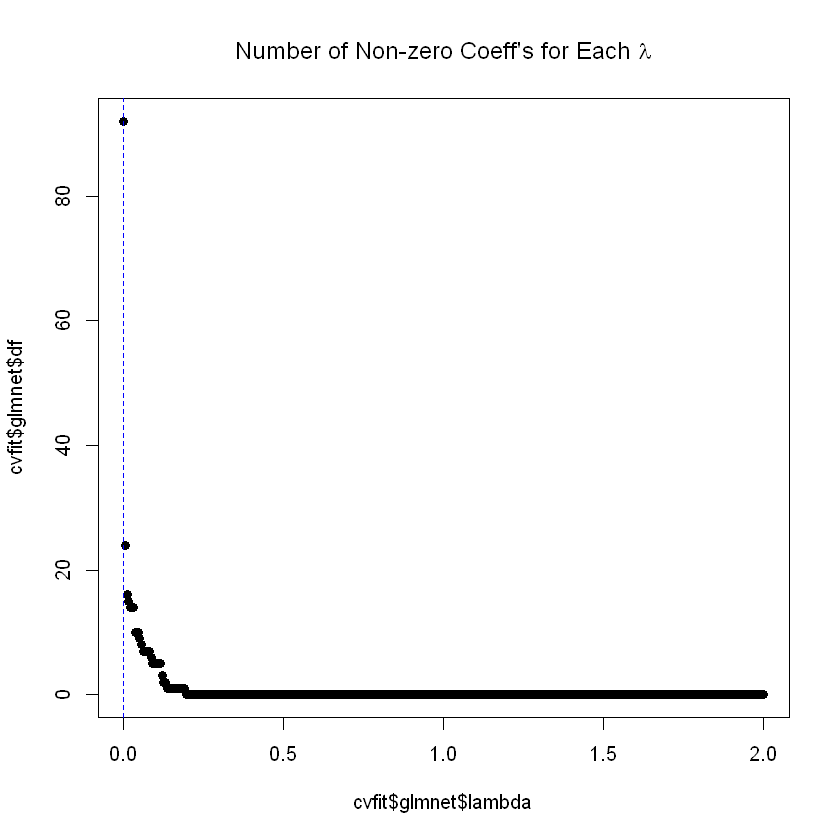

In [27]:
##Number of non-zero coefficients vs. $\lambda$

plot(cvfit$glmnet$lambda,cvfit$glmnet$df, 
     main=TeX("Number of Non-zero Coeff's for Each $\\lambda$"),pch=16)
abline(v=cvfit$lambda.min,col="red",lty="dashed")
abline(v=cvfit$lambda.1se,col="blue",lty="dashed")

In [28]:
ytest = test$Diabetes_binary
Xtest = test[ ,!(names(test) %in% "Diabetes_binary")]

Xtest = model.matrix( ~ ., data=Xtest)[,-1]
pihat = predict(object=cvfit, newx = Xtest, type="response")

Setting levels: control = FALSE, case = TRUE
Warning message in roc.default(response = ylogical, predictor = pihat):
"Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector."Setting direction: controls < cases


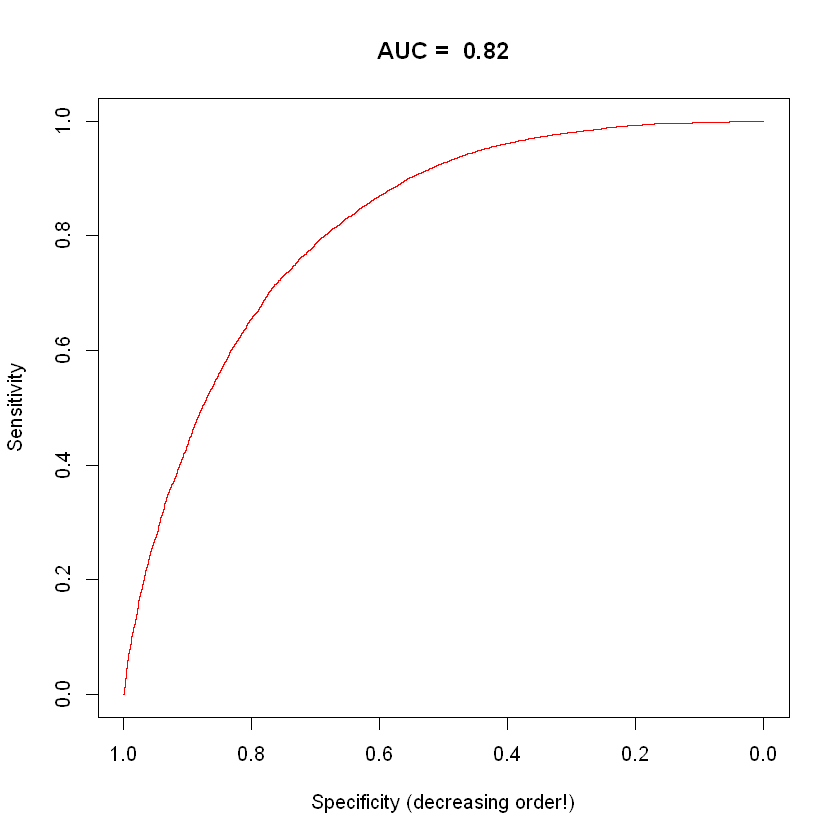

In [29]:
ylogical = (ytest == 1)
ROCcrv = roc(response=ylogical, predictor=pihat)
AUC = auc(ROCcrv)

plot(x=ROCcrv$specificities,y=ROCcrv$sensitivities, main=paste("AUC = ",round(AUC,2)), 
     xlab="Specificity (decreasing order!)", ylab="Sensitivity", xlim=c(1,0), type="l", col="red")

In [30]:
yhat = ifelse(pihat>0.5,"1","0")
tbl = table(yhat, ytest)

tbl

    ytest
yhat    0    1
   0 7587 2478
   1 2983 8160

In [31]:
acc = (tbl[1,1]+tbl[2,2])/sum(tbl)

FNR = tbl[1,2]/sum(tbl[,2])

In [32]:
acc

[1] 0.7425028

In [33]:
FNR

[1] 0.2329385

### Results

Yay! While we did reduce the accuracy to about 75%, we did substantially lower the false negative rate to about 23%. Still a bit too much for my liking however so we are going to try one more time, but this time, we will up-sample the data.

# Up-sampling

In [34]:
up_data = upSample(data[,-1], data$Diabetes_binary, yname="Diabetes_binary")
str(up_data)

'data.frame':	436668 obs. of  22 variables:
 $ HighBP              : Factor w/ 2 levels "0","1": 2 1 2 2 2 2 2 2 1 2 ...
 $ HighChol            : Factor w/ 2 levels "0","1": 2 1 2 1 2 2 1 2 1 2 ...
 $ CholCheck           : Factor w/ 2 levels "0","1": 2 1 2 2 2 2 2 2 2 2 ...
 $ BMI                 : num  40 25 28 27 24 25 30 25 24 34 ...
 $ Smoker              : Factor w/ 2 levels "0","1": 2 2 1 1 1 2 2 2 1 2 ...
 $ Stroke              : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ HeartDiseaseorAttack: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ PhysActivity        : Factor w/ 2 levels "0","1": 1 2 1 2 2 2 1 2 1 1 ...
 $ Fruits              : Factor w/ 2 levels "0","1": 1 1 2 2 2 2 1 1 1 2 ...
 $ Veggies             : Factor w/ 2 levels "0","1": 2 1 1 2 2 2 1 2 2 2 ...
 $ HvyAlcoholConsump   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ AnyHealthcare       : Factor w/ 2 levels "0","1": 2 1 2 2 2 2 2 2 2 2 ...
 $ NoDocbcCost         : Factor w/ 2 levels "

In [35]:
set.seed(227)
trainidx = sample(1:nrow(up_data),size=0.7*nrow(up_data),replace=FALSE)


train = up_data[trainidx, ]
test = up_data[-trainidx, ]

dim(data) #see the dimensions of train data frame

#verify proportions
noquote(paste("proportion of train data:",nrow(train)/nrow(up_data)))
noquote(paste("proportion of test data:",nrow(test)/nrow(up_data)))

[1] 253680     22

[1] proportion of train data: 0.699998625958394

[1] proportion of test data: 0.300001374041606

In [36]:
#get response vector y and predictor matrix (in fact, data frame) X from diabetes data
y = train$Diabetes_binary
X = train[ ,!(names(train) %in% "Diabetes_binary")] #all but Diabetes_binary
dim(X)

[1] 305667     21

In [37]:
X = model.matrix( ~ . , data=X)[,-1]

dim(X)

X[1:5,]

[1] 305667     92

,HighBP1,HighChol1,CholCheck1,BMI,Smoker1,Stroke1,HeartDiseaseorAttack1,PhysActivity1,Fruits1,Veggies1,...,Education4,Education5,Education6,Income2,Income3,Income4,Income5,Income6,Income7,Income8
134529,0,0,1,21,0,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,0
417497,0,0,1,26,0,0,0,1,1,1,...,1,0,0,0,0,1,0,0,0,0
82275,0,0,1,27,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
256669,1,1,1,20,1,0,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
332835,0,0,1,32,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


In [38]:
cvfit = cv.glmnet(X,y,family = "binomial",lambda=mylambda,type.measure="deviance", nfolds = 10, alpha = 1)

In [39]:
coef(cvfit)

93 x 1 sparse Matrix of class "dgCMatrix"
                                  1
(Intercept)           -6.543819e+00
HighBP1                7.212102e-01
HighChol1              5.788730e-01
CholCheck1             1.321596e+00
BMI                    7.121264e-02
Smoker1               -2.078353e-02
Stroke1                1.733612e-01
HeartDiseaseorAttack1  2.636388e-01
PhysActivity1         -5.161192e-02
Fruits1               -5.233529e-02
Veggies1              -4.095757e-02
HvyAlcoholConsump1    -7.203782e-01
AnyHealthcare1         1.019751e-01
NoDocbcCost1           3.909039e-02
GenHlth2               7.480900e-01
GenHlth3               1.446841e+00
GenHlth4               1.887881e+00
GenHlth5               2.039884e+00
MentHlth1             -2.000254e-01
MentHlth2             -1.140225e-01
MentHlth3             -1.466011e-01
MentHlth4             -2.420565e-01
MentHlth5             -1.954924e-01
MentHlth6              4.109824e-02
MentHlth7             -1.150888e-01
MentHlth8             

Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"

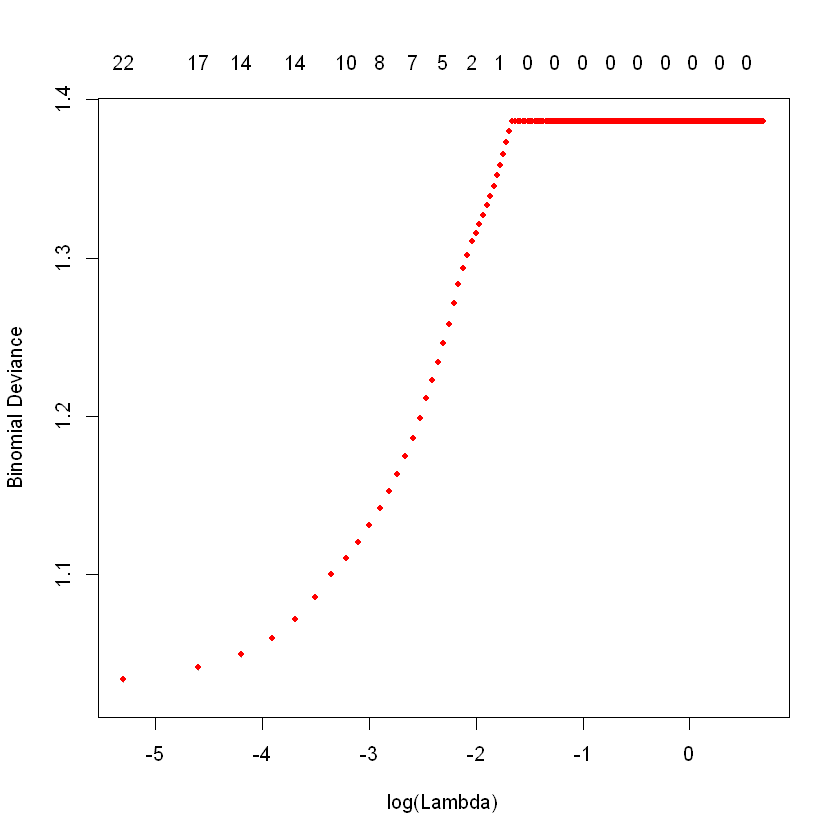

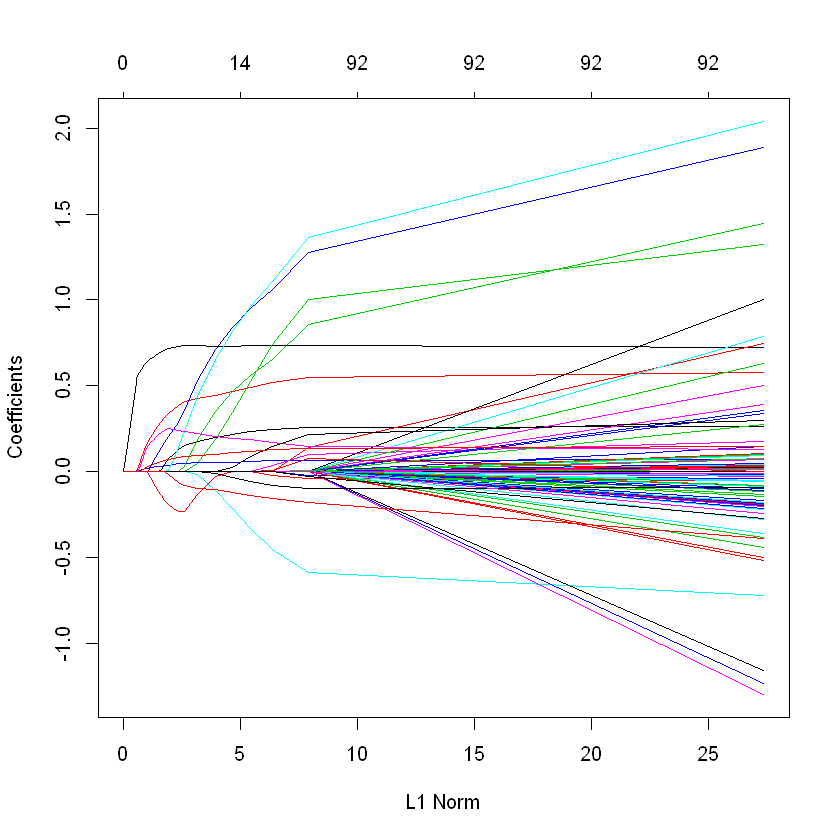

In [40]:
#plot Lasso based on deviance measure
plot(cvfit)  #note on x-axis in the plot is log(lambda), not log(1/lambda)

#plot coefficients for various models; ignore the warning message
plot(cvfit$glmnet.fit)

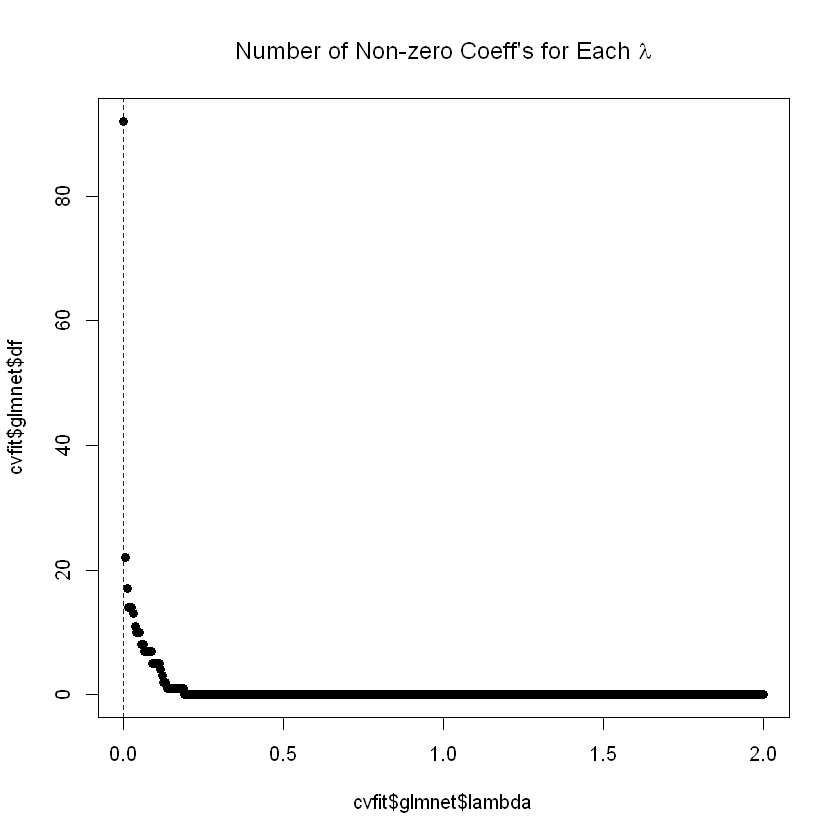

In [41]:
##Number of non-zero coefficients vs. $\lambda$

plot(cvfit$glmnet$lambda,cvfit$glmnet$df, 
     main=TeX("Number of Non-zero Coeff's for Each $\\lambda$"),pch=16)
abline(v=cvfit$lambda.min,col="red",lty="dashed")
abline(v=cvfit$lambda.1se,col="blue",lty="dashed")

In [42]:
ytest = test$Diabetes_binary
Xtest = test[ ,!(names(test) %in% "Diabetes_binary")]

Xtest = model.matrix( ~ ., data=Xtest)[,-1]
pihat = predict(object=cvfit, newx = Xtest, type="response")

Setting levels: control = FALSE, case = TRUE
Warning message in roc.default(response = ylogical, predictor = pihat):
"Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector."Setting direction: controls < cases


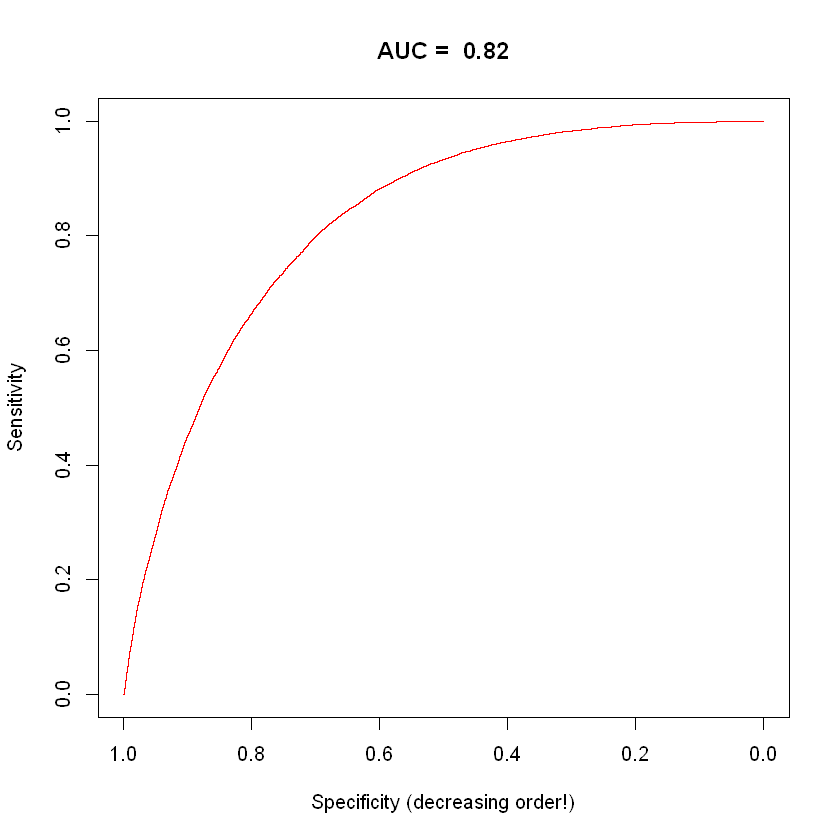

In [43]:
ylogical = (ytest == 1)
ROCcrv = roc(response=ylogical, predictor=pihat)
AUC = auc(ROCcrv)

plot(x=ROCcrv$specificities,y=ROCcrv$sensitivities, main=paste("AUC = ",round(AUC,2)), 
     xlab="Specificity (decreasing order!)", ylab="Sensitivity", xlim=c(1,0), type="l", col="red")

In [44]:
yhat = ifelse(pihat>0.5,"1","0")
tbl = table(yhat, ytest)

tbl

    ytest
yhat     0     1
   0 47428 14846
   1 18302 50425

In [45]:
acc = (tbl[1,1]+tbl[2,2])/sum(tbl)

FNR = tbl[1,2]/sum(tbl[,2])

In [46]:
acc

[1] 0.7469638

In [47]:
FNR

[1] 0.2274517

# Analysis

Overall, it didnt seem like there was much of a difference up-sampling the data vs down-sampling, aside from a slight decrease in the false negative rate. Interestingly enough however, most of our visualizations remained the same. With our AUC values being almost the exact same, it shows that our models will optimize their sensitivities and specificities around the high 70% areas which overall is not too shabby. Additionally, while I expected the lasso regularization to remove some variables, they all still seemed to stick around with the most influential ones of the bunch being the worse end of the General Health questions, about 2 weeks of poor mental health, and large amount of days with physical injuries or illness to name a few.

\
To give this another go and to try and make the model even more precise, lets try to implement a random forest model instead.